In [1]:
#%%importing the necessary libraries
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

#setting the seed for reproducibility
np.random.seed(42)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [3]:
lemma = spacy.load('en_core_web_sm') 

In [4]:
#reading the dataset
raw = pd.read_csv('sent_train.csv')
df = raw.copy()

In [5]:
#defining the function to clean the text
def text_preprocessor(text):
    """
    A function that carries out major text preprocessing activities
    """
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)#removing links
    text = re.sub(r'\$[A-Za-z]+', '', text)  # Remove stock symbols
    text = re.sub(r'\W+', ' ', text.lower())  # Remove non-word characters and convert to lowercase
    text = re.sub(r'\d+', '', text)#removing numbers
    text = re.sub(r'[^\w\s]', ' ', text)#removing punctuation
    text = re.sub(r'\s+[a-zA-Z]\s+|\s+[a-zA-Z]$|^[a-zA-Z]\s+', ' ', text)#remove single letters
    tokens = word_tokenize(text)#tokenizing text
    tokens = [word for word in tokens if word not in stop_words]
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokens]#bringing the words to base form
    

    return lemmatized_text

In [6]:
df['text'] = df['text'].apply(text_preprocessor)

In [7]:
df['text']= [' '.join(text) for text in df['text']]

In [8]:
df['text'].head()

0                jpmorgan reel expectation beyond meat
1    nomura point booking weakness carnival royal c...
2    cemex cut credit suisse p morgan weak building...
3                            btig research cut neutral
4                     funko slide piper jaffray pt cut
Name: text, dtype: object

In [9]:
df['label'].value_counts()


2    6178
1    1923
0    1442
Name: label, dtype: int64

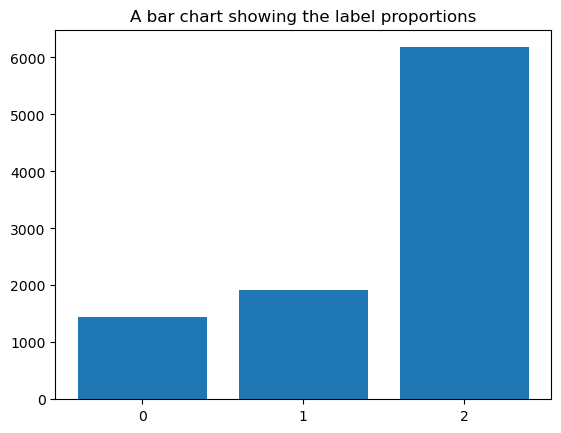

In [10]:
#visualizing the labels
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values)
plt.xticks([0,1,2])
plt.title('A bar chart showing the label proportions')
plt.show()

In [11]:
#subsetting  the words for each sentiment
neutral= df.query('label==2')
bullish= df.query('label==1')
bearish= df.query('label==0')
#Extracting the neutral words for the word cloud
neutral_list= neutral['text'].tolist()
neutralwords = ' '.join([' '.join(inner_list) for inner_list in neutral_list])


#extracting the bullish words for a word cloud
bullish_list= bullish['text'].tolist()
bullishwords = ' '.join([' '.join(inner_list) for inner_list in bullish_list])


#extracting the bearish words for a word cloud
bearish_list= bearish['text'].tolist()
bearishwords = ' '.join([' '.join(inner_list) for inner_list in bearish_list])





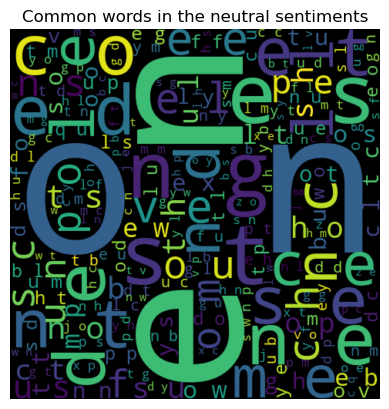

In [12]:
#%%plotting neutral wordclouds
wordcloud_neutral = WordCloud(width=480, height=480, margin=0).generate(neutralwords)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Common words in the neutral sentiments')
plt.show()

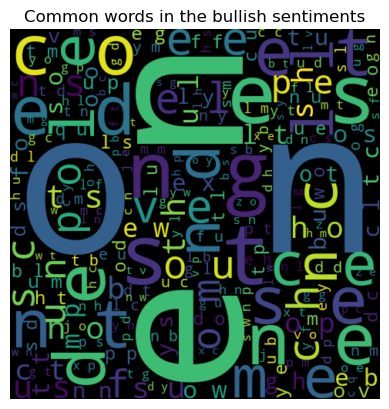

In [13]:
#%%plotting bullish word cloud
wordcloud_bullish = WordCloud(width=480, height=480, margin=0).generate(bullishwords)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Common words in the bullish sentiments')
plt.show()

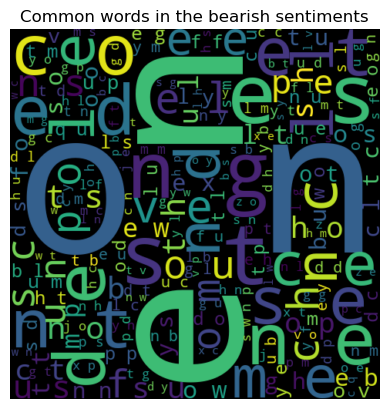

In [14]:
#%%plotting bearish word cloud
wordcloud_bearish = WordCloud(width=480, height=480, margin=0).generate(bearishwords)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.title('Common words in the bearish sentiments')
plt.show()

In [15]:
vectorizer = CountVectorizer(max_features=1000)

In [16]:
#Choosing the X and y variables
X = vectorizer.fit_transform(df['text'])
y= df['label']
#spiliting the dataset into training and validation set
x_train, x_val,y_train, y_val = train_test_split(X, y, test_size=0.3, 
                                                 stratify=y)

#%%model selection

models = [(MultinomialNB(), {'alpha':[0.1, 1,10], 'fit_prior': [True, False]}), 
          (SVC(), {'C':[0.1,1,10], 'kernel':['linear', 'rbf']}), 
          (RandomForestClassifier(), {'n_estimators':[50,100,150], 
                                      'max_depth':[10,20,50]}),
         (LogisticRegression(), {'C':[0.1,1,10]})]

best_models = []
for model, param_grid in models:
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    best_models.append((best_model, grid.best_params_))
    
    
#%%model prediction

for model, params in best_models:
    y_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_pred)
    class_report = classification_report(y_val, y_pred)
    print("Model : ", model, accuracy)
    print("Classification report:",model, class_report)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model :  MultinomialNB(alpha=1) 0.7537548026545582
Classification report: MultinomialNB(alpha=1)               precision    recall  f1-score   support

           0       0.55      0.47      0.51       433
           1       0.65      0.56      0.60       577
           2       0.82      0.88      0.85      1853

    accuracy                           0.75      2863
   macro avg       0.67      0.64      0.65      2863
weighted avg       0.74      0.75      0.75      2863

Model :  SVC(C=10) 0.77645826056584
Classification report: SVC(C=10)               precision    recall  f1-score   support

           0       0.62      0.47      0.53       433
           1       0.71      0.55      0.62       577
           2       0.82      0.92      0.86      1853

    accuracy                           0.78      2863
   macro avg       0.71      0.65      0.67      2863
weighted avg       0.76      0.78      0.76      2863

Model :  RandomForestClassifier(max_depth=50, n_estimators=150) 0.738735

In [17]:
#%%balancing the dataset to increasing precision for 0 label
neutral_b = neutral.sample(n=1442, replace= False, random_state=42)
bullish_b = bullish.sample(n=1442, replace= False, random_state=42)
bearish_b = bearish

balanced_data = pd.concat([neutral_b, bullish_b, bearish_b])

#Splitting balanced data
balanced_data_x = vectorizer.fit_transform(balanced_data['text'])
balanced_data_y = balanced_data['label']
#spiliting the dataset into training and validation set
x_train_b, x_val_b,y_train_b, y_val_b = train_test_split(balanced_data_x, balanced_data_y,
                                                         test_size=0.3, 
                                                         stratify=balanced_data_y)

#%%using the best model on the balanced data
svc_b = SVC(C=10, kernel='rbf')
svc_b.fit(x_train_b, y_train_b)
y_pred_b = svc_b.predict(x_val_b)
accuracy_b = accuracy_score(y_val_b, y_pred_b)
class_report_b = classification_report(y_val_b, y_pred_b)

In [18]:
print(class_report_b)

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       433
           1       0.69      0.68      0.68       432
           2       0.69      0.70      0.69       433

    accuracy                           0.67      1298
   macro avg       0.67      0.67      0.67      1298
weighted avg       0.67      0.67      0.67      1298



## Testing

In [19]:
test = pd.read_csv('sent_valid.csv')
test['text'] = test['text'].apply(text_preprocessor)

In [20]:
test['text']= [' '.join(text) for text in test['text']]

In [21]:
X_test = vectorizer.transform(test['text'])

In [23]:
#predicting with the test data
y_pred_test = svc_b.predict(X_test)
accuracy_b = accuracy_score(test['label'], y_pred_test)
class_report_b = classification_report(test['label'], y_pred_test)

In [25]:
print(class_report_b)

              precision    recall  f1-score   support

           0       0.40      0.68      0.50       347
           1       0.52      0.63      0.57       475
           2       0.90      0.70      0.79      1566

    accuracy                           0.68      2388
   macro avg       0.61      0.67      0.62      2388
weighted avg       0.75      0.68      0.70      2388

